## 연습문제1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성하기

### 데이터셋 불러오기

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
## MNIST 데이터셋은 이미지 데이터형
## as_frame=False 하여 넘파이배열로 데이터를 받아 데이터프레임에 맞추도록

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X,y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Baseline 성능 확인

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

### weights와 n_neighbors로 그리드 탐색 추가하기

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [ ]:
# Best parameter 확인
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
# 성능 확인
grid_search.best_score_

0.9441999999999998

### 최종 성능 확인

In [ ]:
# 최상의 모델을 가져와 전체 훈련 세트에서 다시 훈련하고 성능 확인
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

## 연습문제 2. MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수 만들기

  ✓ 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가

  ✓ 확장된 데이터셋에서 앞에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도를 측정 모델 성능이 더 높아졌는지 확인

  ✓ 데이터 증식 또는 훈련 세트 확장(training set expansion)

In [ ]:
# MNIST 이미지를 왼, 오, 위, 아래 어느 방향으로든 한 픽셀로 이동시킬 수 있는 함수 생성
from scipy.ndimage import shift

def shift_image(image, dx, dy):
  image = image.reshape((28, 28))
  shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
  return shifted_image.reshape([-1])

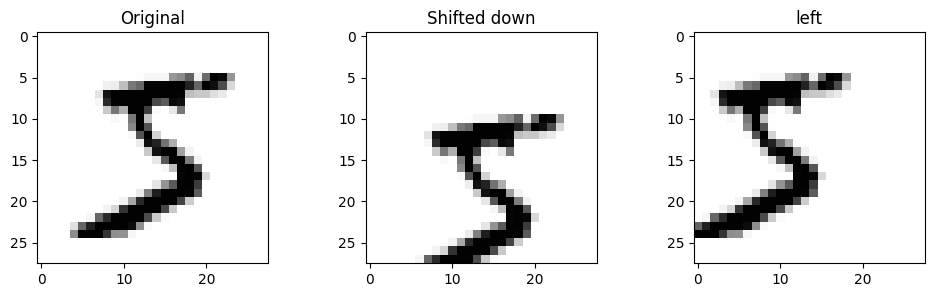

In [ ]:
# 증식된 이미지 시각화해 확인
import matplotlib.pyplot as plt

image = X_train[0]

shifted_image_down = shift_image(image,0,5)
shifted_image_left = shift_image(image,-5,0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28), cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28,28), cmap="Greys")
plt.subplot(133)
plt.title("left")
plt.imshow(shifted_image_left.reshape(28,28), cmap="Greys")
plt.show()

### 모든 이미지를 왼쪽, 오른쪽, 위, 아래로 1픽셀씩 이동하여 증식된 훈련세트 만들기

In [ ]:
import numpy as np

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]
for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
  for image, label in zip(X_train, y_train):
    X_train_augmented.append(shift_image(image, dx, dy))
    y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
# 증식된 훈련세트 섞기(그렇지 않으면 이동된 이미지가 함께 묶임)
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

## 확장된 데이터셋에 앞에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도 측정

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

- ** 기호는 best_params_ 딕셔너리의 키와 값을 함수 인자로 자동으로 풀어서 전달
- best_params_가 {'n_neighbors': 4, 'weights': 'distance’}이었으므로, **를 사용함으로써
KNeighborsClassifier(n_neighbors=4, weights=‘distance’)와 동일한 효과를 가짐

In [ ]:
# 확장된 데이터셋에 대해 훈련
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
# 성능 확인
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763